# Prediction of Forest cover type

## Load Dataset

In [0]:
#Read dataset
!wget -q https://www.dropbox.com/s/lvetpn137577wi8/train_forest_covertype.csv

In [0]:
#Install Packages

!pip -q install plotly-express
!pip -q install shap
!pip -q install eli5
!pip -q install lime

     |████████████████████████████████| 7.1MB 9.4MB/s 
     |████████████████████████████████| 235kB 9.8MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 276kB 10.2MB/s 


## Import Packages

In [0]:
#Import basic packages

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import pandas_profiling
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
%matplotlib inline


In [0]:
!ls

sample_data  train_forest_covertype.csv


## Read data

### 1. Through Pandas

In [0]:
# Read data through Pandas and compute time taken to read

t_start = time.time()
df_forest = pd.read_csv('train_forest_covertype.csv')
t_end = time.time()
print('pd.read_csv(): {} s'.format(t_end-t_start)) # time [s]
df_forest.head()

pd.read_csv(): 0.09636735916137695 s


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [0]:
len(df_forest)

15120

In [0]:
df_forest.Cover_Type.unique()

array([5, 2, 1, 7, 3, 6, 4])

### Through Dask

In [0]:
# Read data through Dask and compute time taken to read

import dask.dataframe as dd

t_start = time.time()
df_dask = dd.read_csv('train_forest_covertype.csv')
t_end = time.time()
print('dd.read_csv(): {} s'.format(t_end-t_start)) # time [s]
df_dask.head()

dd.read_csv(): 0.03913736343383789 s


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


### Subsample into n rows

In [0]:
# Sample n rows
n = 1000
df_forest_sample = df_forest.sample(n)

In [0]:
#Check whether data has been distributed equally among all crews
df_forest_sample['Cover_Type'].value_counts()

4    151
3    151
2    151
5    147
7    141
6    132
1    127
Name: Cover_Type, dtype: int64

In [0]:
df_forest_sample.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
7866,7867,3415,31,6,268,76,1702,219,228,145,1182,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7
9355,9356,3374,230,8,0,0,4320,207,248,177,3551,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7
7630,7631,3432,47,17,600,83,3455,224,201,106,1442,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7
3705,3706,2111,95,13,0,0,969,240,221,110,309,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
14167,14168,2617,122,15,85,13,2045,244,227,107,2656,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


## Exploratory Data Analysis

### Let's look into summary statistics

In [0]:
#Let's look into the total number of columns and observations in the dataset
df_forest_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 7866 to 8290
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil

In [0]:
#Let's look into summary statistics of data
df_forest_sample.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

**Observations:**
There is not much data cleaning to perform.

### Data Cleaning

#### Pandas profiling

In [0]:
#Perform Pandas profiling to understand quick overview of columns

import pandas_profiling
report = pandas_profiling.ProfileReport(df_forest_sample)
#covert profile report as html file
report.to_file("flight_data.html")

In [0]:
from IPython.display import display,HTML,IFrame

display(HTML(open('flight_data.html').read()))

Number of variables,57
Number of observations,15120
Total Missing (%),0.0%
Total size in memory,6.6 MiB
Average record size in memory,456.0 B
Numeric,12
Categorical,0
Boolean,42
Date,0
Text (Unique),0
Rejected,3


#### Removal of unnecessary columns

**Observation:**
- From Pandas profiling we understand id is highly correlated with index and thus can be removed. We will also remove Soil_Type 7 and Soil_Type_15  columns when performing model building.

In [0]:
df_forest_sample.drop(['Soil_Type7','Soil_Type15'],inplace=True,axis=1)

In [0]:
# count the number of NaN values in each column
print(df_forest_sample.isnull().sum())


Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


In [0]:
#The datatypes have now been changed
df_forest_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 7866 to 8290
Data columns (total 54 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil

### Data Visualization

#### Let's check the number of unique cover type

In [0]:
df_forest_sample.Cover_Type.unique()

array([7, 4, 3, 1, 6, 2, 5])

In [0]:
df_forest_sample.Cover_Type.value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

**Observation**:
There are 7 unique cover types and the dataset is balanced.





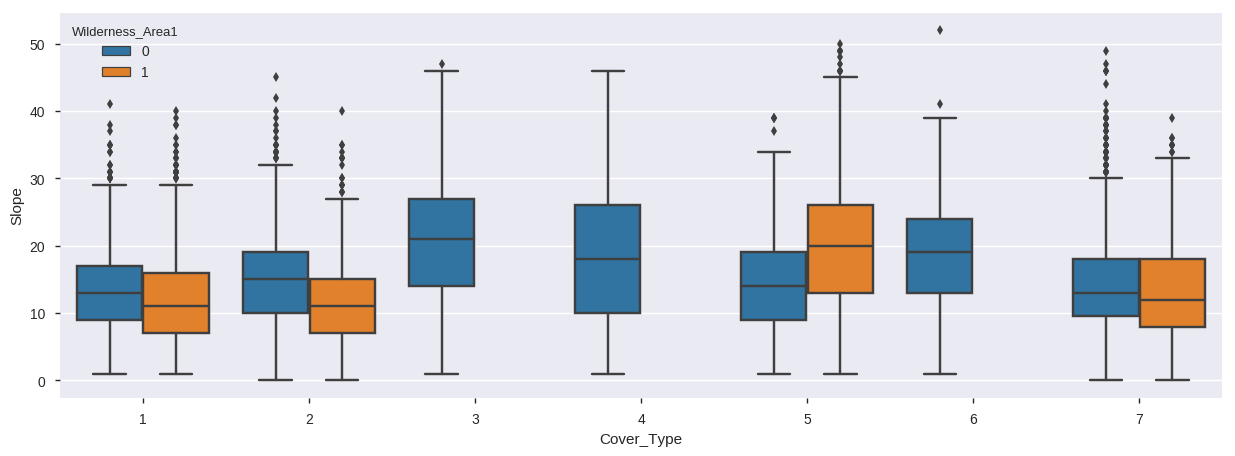

In [0]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Cover_Type", y="Slope", hue='Wilderness_Area1',data = df_forest_sample)

## Model Building

### Prepare the data

In [0]:
# Importing Models
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Importing other tools
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

## Base Line Model Selection 

Model which going to be our baseline -- Every model that we do at later stage should be better than this. 

In [0]:
# Defining random seed
seed=42

# Creating Models

lr = LogisticRegression()
lda = LinearDiscriminantAnalysis()
svc = SVC(random_state=seed, probability=True)
dtree = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(10, random_state=seed)
gdb = GradientBoostingClassifier(random_state=seed)
adb = AdaBoostClassifier(random_state=seed)
xgb = XGBClassifier(random_state=seed)
knn = KNeighborsClassifier()
lgbm = LGBMClassifier(random_state=seed)

first_models = [ lr, lda, svc, dtree, 
                 rf, gdb, adb, xgb, knn, lgbm]
first_model_names = ['Logistic Regression','LDA','SVM','Decision Tree', 
                     'Random Forest', 'GradientBoosting',
                    'AdaBoost', 'XGB', 'K-Neighbors','Light GBM'] 

# Defining other steps
n_folds = 5
skf = model_selection.ShuffleSplit(n_splits = n_folds, test_size = .3, train_size = .7, random_state = seed ) 
std_sca = StandardScaler()

In [0]:
#Standardize rows into uniform scale

X = df_forest_sample.drop(['Cover_Type'],axis=1)
y = df_forest_sample['Cover_Type']




### Initial Model building

In [0]:
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df_forest_sample[['Id']]

train_size = X.shape[0]
n_models = len(first_models)
oof_pred = np.zeros((train_size, n_models))
scores = []
row_index=0

for n, model in enumerate(first_models):
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     ('Estimator', model)])
    MLA_name = model.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(model.get_params())
    
    cv_results = model_selection.cross_validate(model, X, y, cv  = skf, return_train_score=True,scoring=None)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()  
    
    model_pipeline.fit(X, y)
    MLA_predict[MLA_name] = model_pipeline.predict(X)
    row_index+=1
        

In [0]:
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
MLA_compare['Differenec'] = (MLA_compare['MLA Test Accuracy Mean'] - MLA_compare['MLA Train Accuracy Mean'])*100
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,Differenec
5,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",1,0.685333,1.1285,-31.4667
7,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.956286,0.684,1.03432,-27.2286
9,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",1,0.669333,0.619997,-33.0667
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.993429,0.649333,0.0176567,-34.4095
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.704286,0.633333,0.151752,-7.09524
1,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.687714,0.619333,0.0140795,-6.8381
3,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.614667,0.00899553,-38.5333
8,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.719143,0.556,0.00344639,-16.3143
6,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.44,0.404,0.100346,-3.6
2,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",1,0.124667,0.39062,-87.5333


In [0]:
MLA_predict.head(10)

,Id,LogisticRegression,LinearDiscriminantAnalysis,SVC,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,XGBClassifier,KNeighborsClassifier,LGBMClassifier
7866,7867,7,7,7,7,7,7,1,7,7,7
9355,9356,7,7,7,7,7,7,1,7,7,7
7630,7631,7,7,7,7,7,7,7,7,7,7
3705,3706,4,4,4,4,4,4,6,4,4,4
14167,14168,3,3,3,3,3,3,6,3,3,3
7343,7344,1,1,1,1,1,1,1,1,7,1
6409,6410,6,6,6,6,6,6,6,6,6,6
8108,8109,7,7,7,7,7,7,1,7,7,7
552,553,2,2,2,2,2,2,5,2,2,2
3842,3843,4,3,4,4,4,4,6,4,6,4


### Understand feature importance

In [0]:
feature_names = X.columns
feat_imp_df = pd.DataFrame(columns=first_model_names, index=feature_names)

# Dropping the Models that don't have feature importances for this analysis
feat_imp_df.drop(['SVM','K-Neighbors'], axis=1, inplace=True)


# I'm using absolute values for logistic Regression and LDA because we only care about the magnitude of the coefficient, not its direction 
#feat_imp_df['Logistic Regression'] = np.abs(lr.coef_.ravel())
#feat_imp_df['LDA'] = np.abs(lda.coef_.flatten())
feat_imp_df['Decision Tree'] = dtree.feature_importances_
feat_imp_df['Random Forest'] = rf.feature_importances_
feat_imp_df['GradientBoosting'] = gdb.feature_importances_
feat_imp_df['AdaBoost'] = adb.feature_importances_
feat_imp_df['XGB'] = xgb.feature_importances_
feat_imp_df['Light GBM'] = lgbm.feature_importances_
feat_imp_df

,Logistic Regression,LDA,Decision Tree,Random Forest,GradientBoosting,AdaBoost,XGB,Light GBM
Id,NaN,NaN,0.059661,0.072816,0.083690,0.00,0.026457,2359
Elevation,NaN,NaN,0.421951,0.155097,0.476233,0.52,0.098682,3980
Aspect,NaN,NaN,0.034310,0.051267,0.025165,0.00,0.012303,1289
Slope,NaN,NaN,0.023192,0.054489,0.009620,0.00,0.013682,915
Horizontal_Distance_To_Hydrology,NaN,NaN,0.043610,0.055482,0.038732,0.00,0.022886,1495
Vertical_Distance_To_Hydrology,NaN,NaN,0.051769,0.056800,0.026158,0.48,0.015729,1385
Horizontal_Distance_To_Roadways,NaN,NaN,0.075921,0.088219,0.042674,0.00,0.016735,2347
Hillshade_9am,NaN,NaN,0.064108,0.054320,0.050581,0.00,0.038290,1454
Hillshade_Noon,NaN,NaN,0.044404,0.047764,0.013835,0.00,0.012854,1153
Hillshade_3pm,NaN,NaN,0.015611,0.046946,0.013014,0.00,0.012100,955


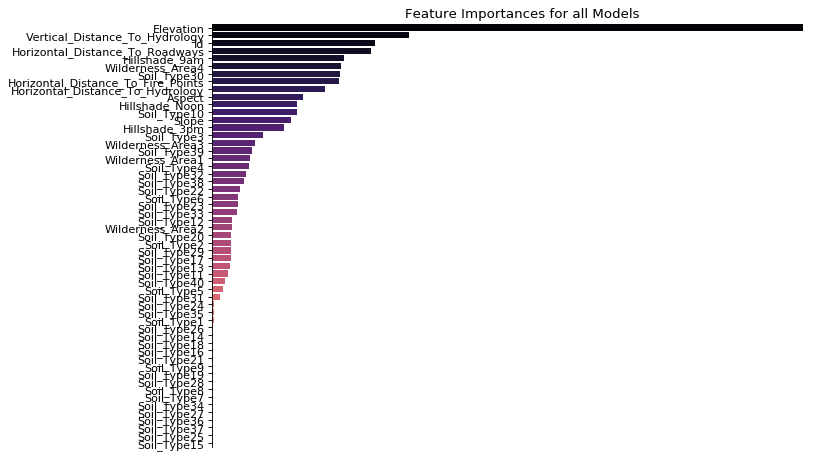

In [0]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

scaled_fi = pd.DataFrame(data=mms.fit_transform(feat_imp_df),
                         columns=feat_imp_df.columns,
                         index=feat_imp_df.index)
scaled_fi['Overall'] = scaled_fi.sum(axis=1)

ordered_ranking = scaled_fi.sort_values('Overall', ascending=False)
fig, ax = plt.subplots(figsize=(10,7), dpi=80)
sns.barplot(data=ordered_ranking, y=ordered_ranking.index, x='Overall', palette='magma')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)
ax.grid(False)
ax.set_title('Feature Importances for all Models');

In [0]:
list(scaled_fi[:10].index)

['Id',
 'Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm']

In [0]:
 X =  X[list(scaled_fi[:10].index)].head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm
12384,12385,2137,100,36,124,65,579,251,168,0
9704,9705,3823,20,13,1092,374,4660,210,211,136
10881,10882,2590,93,24,85,-3,2190,249,194,59
3065,3066,2323,38,28,400,245,658,207,166,78
2883,2884,2194,341,34,270,153,319,130,169,165


In [0]:
ordered_ranking.index[:-20:-1]

Index(['Soil_Type8', 'Soil_Type25', 'Soil_Type28', 'Soil_Type9', 'Soil_Type36',
       'Soil_Type21', 'Soil_Type19', 'Soil_Type27', 'Soil_Type18',
       'Soil_Type26', 'Soil_Type37', 'Soil_Type34', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type35', 'Soil_Type1', 'Soil_Type29',
       'Wilderness_Area2', 'Soil_Type11'],
      dtype='object')

In [0]:
train_v2 = df_forest_sample.drop(ordered_ranking.index[:-20:-1], axis=1)

X_v1 = train_v2.drop(['Cover_Type'],axis=1)
y_v1 = train_v2['Cover_Type']



### Model Building after removing irrelevant features

In [0]:
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = train_v2[['Id']]

train_size = X_v1.shape[0]
n_models = len(first_models)
oof_pred = np.zeros((train_size, n_models))
scores = []
row_index=0

for n, model in enumerate(first_models):
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     ('Estimator', model)])
    MLA_name = model.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(model.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(model, X_v1, y_v1, cv  = skf, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()  
    
    model_pipeline.fit(X_v1, y_v1)
    MLA_predict[MLA_name] = model_pipeline.predict(X_v1)
    
    #model_pipeline.fit(X, y)
    #val_pred = model_pipeline.predict(x_val)
    #oof_pred[X, n] = model_pipeline.predict_proba(X)[:,1]
    row_index+=1
        

In [0]:
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
MLA_compare['Differenec'] = (MLA_compare['MLA Test Accuracy Mean'] - MLA_compare['MLA Train Accuracy Mean'])*100
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,Differenec
7,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.954286,0.682667,0.706702,-27.1619
5,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",1,0.682667,1.03205,-31.7333
9,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",1,0.669333,0.600438,-33.0667
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.993429,0.663333,0.0178261,-33.0095
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.706571,0.643333,0.144124,-6.32381
1,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.686857,0.628667,0.00676894,-5.81905
3,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.604667,0.00798059,-39.5333
8,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.719143,0.556,0.00243902,-16.3143
6,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.44,0.404,0.094662,-3.6
2,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",1,0.124667,0.281764,-87.5333


### GridSearchCV

In [0]:
first_models = [rf,lgbm,knn]
first_model_names = ['rf','lgbm', 'knn'] 

In [0]:
LGBM_param_grid = {'lgbm__learning_rate': [0.1],
    'lgbm__n_estimators': [100],
    'lgbm__num_leaves': [31], # large num_leaves helps improve accuracy but might lead to over-fitting
    'lgbm__boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    
                  }

RF_param_grid = {
                
               'rf__n_estimators': [100,200], #default=10
            'rf__criterion': ['gini', 'entropy'], #default=”gini”
            'rf__max_depth': [2,4,8] ,#default=None
            'rf__oob_score': ['True']
}

GDB_param_grid = {
    "gdb__loss":["deviance"],
    "gdb__learning_rate": [0.01,0.1],
    
    "gdb__max_depth":[3,5],
   
    "gdb__criterion": ["friedman_mse",  "mae"],
    
    "gdb__n_estimators":[10]
    
}
XGB_param_grid = {
    'xgb__min_child_weight': [1, 5],
        'xgb__gamma': [0.5, 1],
        'xgb__max_depth': [3, 4, 5]
}

KNN_param_grid = {
    'knn__n_neighbors':[5,6,7],
          'knn__leaf_size':[1,2,3,5],
          
}

In [0]:
from sklearn.model_selection import GridSearchCV
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
#models = [LGBMClassifier(),RandomForestClassifier()]
params_grid = [RF_param_grid,LGBM_param_grid,KNN_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for n,alg in enumerate(first_models):
    print(alg)
    model_pipeline = Pipeline(steps=[('Scaler', std_sca),
                                     (first_model_names[n], first_models[n])])
    
    gs_alg = GridSearchCV(model_pipeline, param_grid = params_grid[0], cv = skf, scoring = 'accuracy', n_jobs=-1,return_train_score=True)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_v1, y_v1)
   
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
 
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = gs_alg.cv_results_['mean_train_score'][gs_alg.best_index_]
    after_model_compare.loc[row_index, 'Test Accuracy'] = gs_alg.cv_results_['mean_test_score'][gs_alg.best_index_]
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

after_model_compare

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
1 RandomForestClassifier trained...
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
2 LGBMClassifier tr

,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,RandomForestClassifier,"{'rf__criterion': 'gini', 'rf__max_depth': 8, ...",0.957714,0.693333
1,LGBMClassifier,"{'lgbm__boosting_type': 'gbdt', 'lgbm__learnin...",1,0.67
2,KNeighborsClassifier,"{'knn__leaf_size': 1, 'knn__n_neighbors': 6}",0.730571,0.613333


In [0]:
after_model_compare['Difference'] = after_model_compare['Test Accuracy']-after_model_compare['Train Accuracy Mean']

In [0]:
after_model_compare

,Name,Parameters,Train Accuracy Mean,Test Accuracy,Difference
0,RandomForestClassifier,"{'rf__criterion': 'gini', 'rf__max_depth': 8, ...",0.957714,0.693333,-0.264381
1,LGBMClassifier,"{'lgbm__boosting_type': 'gbdt', 'lgbm__learnin...",1,0.67,-0.33
2,KNeighborsClassifier,"{'knn__leaf_size': 1, 'knn__n_neighbors': 6}",0.730571,0.613333,-0.117238


### Stacking

#### Through voting classifier

In [0]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    
    ('rfc', ensemble.RandomForestClassifier()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())
  

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X, y, cv  = skf,return_train_score=True)
vote_hard.fit(X, y)
#print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Train w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100))
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X, y, cv  = skf,return_train_score=True)
vote_soft.fit(X, y)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
# print("Soft Voting Train w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100))
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Train w/bin score mean: 97.49
Hard Voting Test w/bin score mean: 68.47
Hard Voting Test w/bin score 3*std: +/- 6.65
----------
Soft Voting Training w/bin score mean: 98.69
Soft Voting Test w/bin score mean: 71.07
Soft Voting Test w/bin score 3*std: +/- 9.24
----------


#### Through mlxtend

In [0]:
from mlxtend.classifier import StackingClassifier

In [0]:
lgbm_cl = LGBMClassifier(random_state=seed)
lgbm_cl.set_params = after_model_compare['Parameters'][1]

In [0]:
rf_cl = RandomForestClassifier(10, random_state=seed)

In [0]:
gdb_cl = GradientBoostingClassifier(random_state=seed)

In [0]:
logreg = LogisticRegression()

In [0]:
sclf = StackingClassifier(classifiers=[lgbm_cl, rf_cl],
                          meta_classifier=logreg)

scores = model_selection.cross_val_score(sclf, X_v1, y_v1, 
                                              cv=5, scoring='accuracy')
p
print("Accuracy: %0.2f (+/- %0.2f)" 
      % (scores.mean(), scores.std()))


# label = ['LGBM', 'Random Forest','GDB' 'Stacking Classifier']
# clf_list = [lgbm_cl, rf_cl,gdb_cl, logreg]

Accuracy: 0.59 (+/- 0.02)


In [0]:
print (scores)

[0.57560976 0.5920398  0.57575758 0.61616162 0.60606061]


In [0]:
# for clf, label in zip([lgbm_cl, rf_cl,gdb_cl,sclf], 
#                       ['LGBM', 
#                        'Random Forest', 
#                        'GDB',
#                        'StackingClassifier']):

#     scores = model_selection.cross_val_score(clf, X_v1, y_v1, 
#                                               cv=3, scoring='accuracy')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
#           % (scores.mean(), scores.std(), label))

Accuracy: 0.86 (+/- 0.01) [LGBM]
Accuracy: 0.83 (+/- 0.01) [Random Forest]
Accuracy: 0.81 (+/- 0.00) [GDB]
Accuracy: 0.81 (+/- 0.00) [StackingClassifier]


In [0]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.3.0-cp36-none-any.whl size=19435 sha256=8023c0db55fb2a8e6f6e7868a938e9ee5c1ee63315e51b7ea476a64d4cfce3cf
  Stored in directory: /root/.cache/pip/wheels/35/6d/ca/bce17942bcf7c267b13c97c9c95e2f0ecf0b42160e6074f448
Successfully built vecstack


#### Through vecstack

In [0]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.3.0-cp36-none-any.whl size=19435 sha256=d0712be060721866bcc4e9e0e567cd63be132f5bf08fdf9493f633b54e6ad3b3
  Stored in directory: /root/.cache/pip/wheels/35/6d/ca/bce17942bcf7c267b13c97c9c95e2f0ecf0b42160e6074f448
Successfully built vecstack


In [0]:
from vecstack import stacking

In [0]:
#1st level model -- Base Learner
X_train, X_test, y_train, y_test = train_test_split(X_v1, y_v1, test_size=0.2)

models = [lgbm_cl,rf_cl,gdb_cl]
S_train, S_test = stacking(models, X_train, y_train, X_test, 
    regression = False, metric = accuracy_score, n_folds = 4 , 
    shuffle = True, random_state = 0, verbose = 2)

task:         [classification]
n_classes:    [7]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LGBMClassifier]
    fold  0:  [0.62500000]
    fold  1:  [0.71000000]
    fold  2:  [0.72000000]
    fold  3:  [0.67000000]
    ----
    MEAN:     [0.68125000] + [0.03747916]
    FULL:     [0.68125000]

model  1:     [RandomForestClassifier]
    fold  0:  [0.68500000]
    fold  1:  [0.66500000]
    fold  2:  [0.68000000]
    fold  3:  [0.68000000]
    ----
    MEAN:     [0.67750000] + [0.00750000]
    FULL:     [0.67750000]

model  2:     [GradientBoostingClassifier]
    fold  0:  [0.69000000]
    fold  1:  [0.75000000]
    fold  2:  [0.68500000]
    fold  3:  [0.68000000]
    ----
    MEAN:     [0.70125000] + [0.02836701]
    FULL:     [0.70125000]



In [0]:
#2nd level model  #Meta Learner
models = [xgb]
S_train, S_test = stacking(models, S_train, y_train, S_test, 
    regression = False, metric = accuracy_score, n_folds = 4 , 
    shuffle = True, random_state = 0, verbose = 2)

task:         [classification]
n_classes:    [7]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [XGBClassifier]
    fold  0:  [0.70500000]
    fold  1:  [0.73000000]
    fold  2:  [0.67500000]
    fold  3:  [0.72000000]
    ----
    MEAN:     [0.70750000] + [0.02076656]
    FULL:     [0.70750000]



### Model Explainability

In [0]:
from sklearn import metrics
model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3)
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % metrics.accuracy_score(y_test, y_pred))

Final prediction score: [0.65500000]
